In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import norm
import scipy.integrate as integrate
from scipy import optimize

In [2]:
# set plotting style
import seaborn as sns
sns.set_theme()

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%matplotlib inline

# 1. Term Structure of Interest Rates 

In this project, I assume the stochastic interest rates under a two-factor Vasicek interest rate model. Let $r=(r_t)_{t\geq 0}$ represent the short rate of interest and $r$ satisfies the following Stochastic Differential Equations (SDE):

\begin{align}
    dr_t&=\alpha(\theta_t-r_t)dt+\sigma \ dW_t^1 \label{r_t SDE} \\ 
    d\theta_t&=\beta(\phi-\theta_t)dt + \eta \ dW_t^2 \label{theta_t SDE}
\end{align}

where $W^{1,2}=(W_t^{1,2})_{t\geq0}$ are two independent risk-neutral Brownian Motions. Notice that the short rate of interest $r=(r_t)_{t\geq 0}$ is an Ornstein-Uhlenbeck (OU) process that mean-reverts to the long-run interest rate denoted by $\theta_t$ at a rate of $\alpha$, the long-run interest rate $\theta=(\theta_t)_{t\geq0}$ itself is also an OU process with a mean-reversion level $\phi$ at a rate of $\beta$.

In addition, I assume the following set of base parameters:

$\hspace{1cm} r_0 = 2\%,\hspace{0.5cm} \alpha = 3,\hspace{0.5cm}\sigma = 1\%,\hspace{0.5cm}\theta_0 =3\%, \hspace{0.5cm}\beta=1, \hspace{0.5cm}\phi=5\%, \hspace{0.5cm}\eta=0.5\%$

## 1.1 Short-Run Rate and Long-Run Rate Simulation

In [3]:
# model base parameters
r_0 = 0.02
alpha = 3
sigma = 0.01
theta_0 = 0.03
beta = 1
fi = 0.05
eta = 0.005

In [4]:
# time grid
T = 10
NdT = 365*T
t = np.linspace(0,T,NdT)
dt = t[1]-t[0]

In [5]:
def SimTheta(t, beta, fi, eta, Nsims):
    
    NdT = len(t)
    dt = t[1] - t[0]
    sqrt_dt = np.sqrt(dt)
    
    theta = np.zeros((Nsims, NdT))
    
    theta[:,0] = theta_0
    
    for i in range(len(t)-1):
        
        theta[:,i+1] = theta[:,i]+beta*(fi-theta[:,i])*dt+eta*sqrt_dt*np.random.randn(Nsims)
    return theta

In [6]:
theta = SimTheta(t,beta,fi,eta,Nsims=1000)

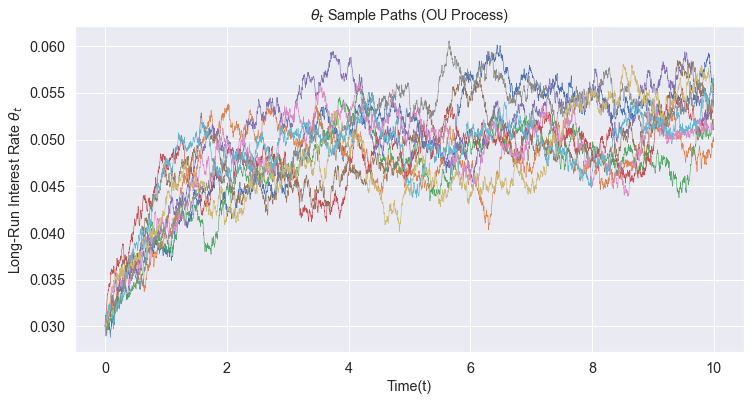

In [7]:
plt.figure(figsize=(12,6))
for i in range(0,10):
    plt.plot(t,theta[i,:],linewidth=0.6)
plt.title(r'$\theta_t$ Sample Paths (OU Process)')
plt.xlabel('Time(t)')
plt.ylabel(r'Long-Run Interest Rate $\theta_t$')
plt.show()

In [8]:
fig = go.Figure()
for i in range(5):
    fig.add_trace(go.Scatter(x=t, y=theta[i,:], name="path " + str(i+1)) )

fig.update_layout(
    title=r"$\theta_t\quad\text{Sample Paths (OU Process)}$",
    xaxis_title=r"$t$",
    yaxis_title=r"$\theta_t$",
    font=dict(
        size=18,
        color="RebeccaPurple") )

fig.show()

In [9]:
def SimR(t, alpha, theta, sigma, Nsims):
    
    NdT = len(t)
    dt = t[1] - t[0]
    sqrt_dt = np.sqrt(dt)
    
    r_t = np.zeros((Nsims, NdT))
    
    r_t[:,0] = r_0
    
    for i in range(len(t)-1):
        
        r_t[:,i+1] = r_t[:,i]+alpha*(theta[:,i]-r_t[:,i])*dt+sigma*sqrt_dt*np.random.randn(Nsims)
        
    return r_t

In [10]:
r_t = SimR(t,alpha,theta,sigma,Nsims=1000)

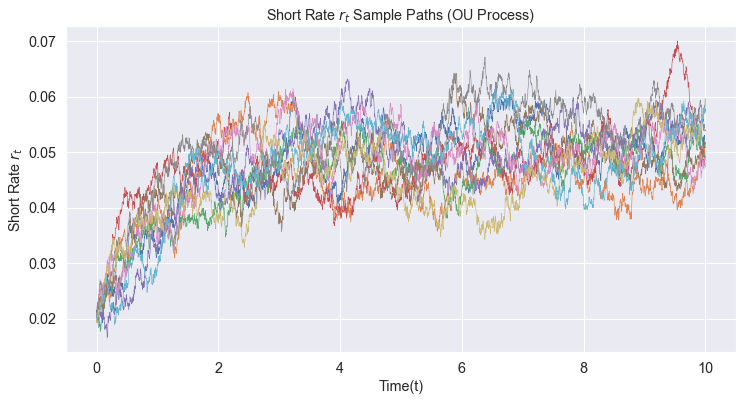

In [11]:
plt.figure(figsize=(12,6))
for i in range(0,10):
    plt.plot(t,r_t[i,:],linewidth=0.6)
plt.title('Short Rate $r_t$ Sample Paths (OU Process)')
plt.xlabel('Time(t)')
plt.ylabel(r'Short Rate $r_t$')
plt.show()

In [12]:
fig = go.Figure()
for i in range(5):
    fig.add_trace(go.Scatter(x=t, y=r_t[i,:], name="path " + str(i+1)) )

fig.update_layout(
    title=r"$r_t\quad\text{Sample Paths}$",
    xaxis_title=r"$t$",
    yaxis_title=r"$r_t$",
    font=dict(
        size=18,
        color="RebeccaPurple") )

fig.show()

In [13]:
theta = SimTheta(t,beta,fi,eta,Nsims=1000)
r_t = SimR(t,alpha,theta,sigma,Nsims=1000)

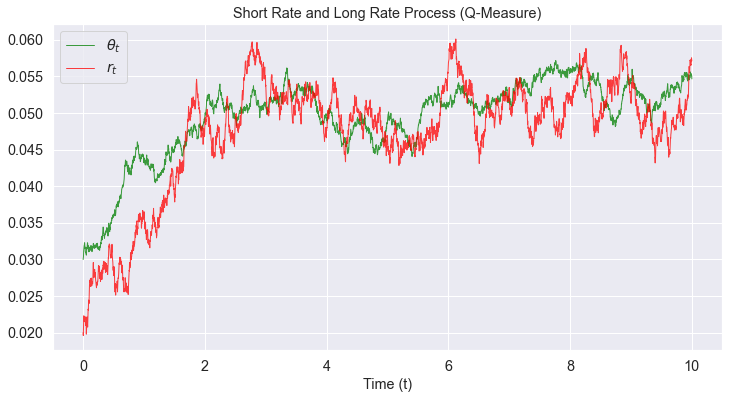

In [14]:
plt.figure(figsize=(12,6))
plt.plot(t,theta[1,:],linewidth=1,color='green',alpha=0.75,label=r"$\theta_t$")
plt.plot(t,r_t[1,:],linewidth=1,color="red",alpha=0.75,label=r"$r_t$")
plt.xlabel(r"Time (t)")
plt.title("Short Rate and Long Rate Process (Q-Measure)")
plt.legend()
plt.show()

## 1.2 Monte Carlo Simulation

I simulate the interest rate under Euler-scheme, with generated simulations of risk-neutral interest rate paths, I can obtain the Monte Carlo estimate of bond yields (with confidence bands)

In [15]:
def MCBondYield_Price(t,r_t,Nsims):
    '''
    This function returns a bond-yield vector based on the simulated short rate process
    '''
    
    # discretized increment
    increment_t = np.zeros((Nsims, NdT))
    for i in range(1,len(t)):
        increment_t[:,i] = r_t[:,i-1] * dt
    
    # integral of short rate process
    integral_t = np.zeros((Nsims, NdT))
    integral_t = np.cumsum(increment_t,axis=1)
    
    # bond price calculation
    bond_price = np.mean(np.exp(-integral_t),axis=0)
    
    # bond yield calculation
    bond_yield = np.zeros(len(t))
    bond_yield[0] = np.mean(r_t[:,0])
    bond_yield[1:] = - np.log(bond_price[1:]) / t[1:]
    
    return bond_yield, bond_price

In [16]:
bond_yield_avg, bond_price = MCBondYield_Price(t,r_t,Nsims=1000)

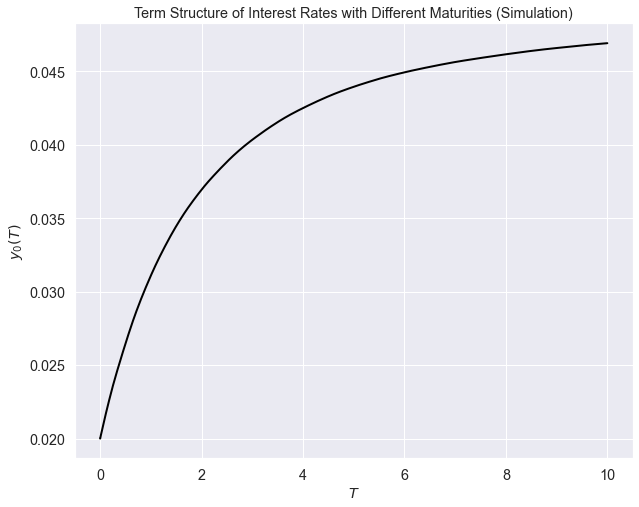

In [17]:
plt.figure(figsize=(10,8))
plt.plot(t,bond_yield_avg,linewidth=2,color='black')
plt.xlabel(r"$T$")
plt.ylabel(r"$y_0(T)$")
plt.title("Term Structure of Interest Rates with Different Maturities (Simulation)")
plt.show()

In [18]:
confidence_bands = [0.025, 0.975]
r_confidence_bands = np.quantile(r_t, confidence_bands, axis=0)

In [19]:
# discretized increments
increment_t2 = np.zeros((2, NdT))
for i in range(1,len(t)):
    increment_t2[:,i] = r_confidence_bands[:,i-1] * dt

In [20]:
# integral of short rate process
integral_t2 = np.zeros((2,NdT))
integral_t2 = np.cumsum(increment_t2,axis=1)

In [21]:
# bond price calculation
bond_price2 = np.exp(-integral_t2)

In [22]:
# bond yield calculation
bond_yield2 = np.zeros((2,NdT))
bond_yield2[:,0] = r_confidence_bands[:,0]
tt = np.tile(t,(2,1))
bond_yield2[:,1:] = - np.log(bond_price2[:,1:]) / tt[:,1:]

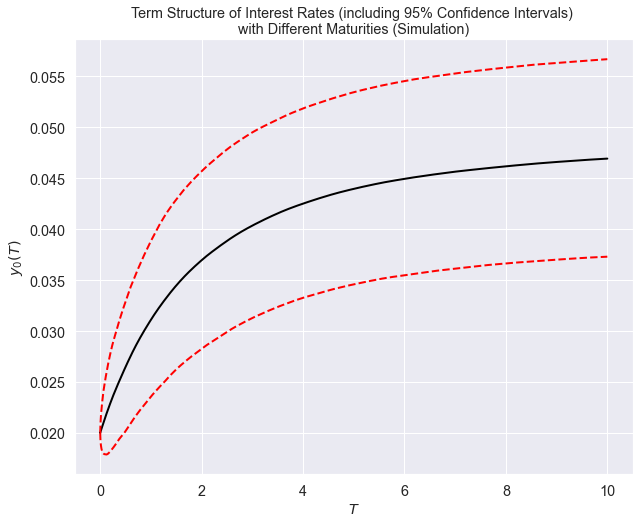

In [23]:
plt.figure(figsize=(10,8))
plt.plot(t,bond_yield_avg,linewidth=2,color='black')
plt.plot(tt[0,:],bond_yield2[0,:],linewidth=2,linestyle='dashed',color="red");
plt.plot(tt[1,:],bond_yield2[1,:],linewidth=2,linestyle='dashed',color="red");
plt.xlabel(r"$T$")
plt.ylabel(r"$y_0(T)$")
plt.title("Term Structure of Interest Rates (including 95% Confidence Intervals) \nwith Different Maturities (Simulation)")
plt.show()

## 1.3 Analytical Bond Yields

Let the $T$-maturity bond price process be denoted $P(T) = (P_t(T))_{t \in [0,T]}$. Furthermore, assume that the price process of a claim written on $r$ with payoff function $F(r), f = (f_t)_{t \geq 0}$ is Markovian in $r$, i.e., there exists a function $f$ such that $f_t = f(t,r_t,\theta_t)$. Then by the dynamic hedging argument, the function $r$ satisfies the PDE:

\begin{equation} \label{PDE}
    \left\{ 
    \begin{array}{ll}
         (\partial_t+\mathcal{L})f(t,r,\theta) = rf(t,r,\theta) \\
         F(T,r,\theta) = 1 
    \end{array}
    \right.
\end{equation}
where 
\begin{equation*}
    \mathcal{L} = \alpha(\theta-r)\partial_r+\frac{1}{2}\sigma^2\partial_{rr}+\beta(\phi-\theta)\partial_{\theta}+\frac{1}{2}\eta^2\partial_{\theta\theta}
\end{equation*}

According to the Feynman-Kac theorem, the solution to the above PDE is:

\begin{equation}
    P_t(T) = f(t,r,\theta) = \mathbb{E}_t^\mathbb{Q}[F(T,r,\theta)\cdot e^{-\int_t^T r_s ds}]
\end{equation}

Because coefficients are at most linear in $r$ and $\theta$, solution must be of the form:

\begin{equation}
P_t(T) = e^{A_t(T) - B_t(T) r_t - C_t(T)\theta_t}
\end{equation}

Since $P_T(T) = 1$ for any $r$ and $\theta$, 

\begin{equation}
    A_T = B_T = C_T = 0
\end{equation}

Then I take the partial derivative of $f(t,r,\theta)$ and obtain that:

\begin{equation*}
    \left\{ \begin{array}{rcl}
         \partial_t f =  (\dot A - \dot B - \dot C)f \\
         \partial_r f = -Bf \\
         \partial_{\theta}f = -Cf\\
         \partial_{rr}f = B^2f \\
         \partial_{\theta\theta}f = C^2f
    \end{array}\right.
\end{equation*}

where $\dot A$, $\dot B$ and $\dot C$ are the derivatives of the deterministic functions $A_t(T)$, $B_t(T)$ and $C_t(T)$ with respect to $t$, respectively.

Substituting all the partial derivatives into the PDE, I get:

\begin{align*}
    (-\dot C-\alpha B+\beta C) \theta f + (-\dot B+\alpha B-1)rf + (\dot A+\frac{1}{2}\sigma^2B^2-\beta\phi Cf+\frac{1}{2}\eta^2C^2)f &= 0
\end{align*}

Since $f > 0$ all the time, to ensure this equation hold for all $f$ under any $r, t, \theta$, the coffeficients in front of $f$ should all be equal to zero. This gives us a system of ODEs:

\begin{equation*}
    \dot C+\alpha B-\beta C = 0\\
    \dot B-\alpha B+1 = 0\\
    \dot A+\frac{1}{2}\sigma^2B^2-\beta\phi C+\frac{1}{2}\eta^2C^2 = 0 
\end{equation*}

First, I solve the second ODE with the boundary condition $B_T = 0$, I get that

\begin{equation}\label{Bt}
    B_t(T) = \frac{1-e^{-\alpha(T-t)}}{\alpha}
\end{equation}

Then with $B_t(T)$ solution, I substitute that into the first ODE, I can get

\begin{equation}\label{Ct}
    C_t(T) = \frac{\alpha}{\alpha-\beta}\cdot(\frac{1-e^{-\beta(T-t)}}{\beta} - \frac{1-e^{-\alpha(T-t)}}{\alpha})
\end{equation}


The last step is to solve $A_t(T)$, with $B_t(T)$ and $C_t(T)$ substituting into the third ODE.

\begin{equation}
    A_t(T) = (B_t(T) - \tau) (\phi - \frac{\sigma^2}{2\alpha^2}) + C_t(T)\phi - \frac{\sigma^2B_t(T)^2}{4\alpha}\\
    +\frac{\eta^2}{2}[\ \frac{\tau}{\beta^2} - 2\cdot\frac{C_t(T)+B_t(T)}{\beta^2} + \frac{1}{(\alpha-\beta)^2}\cdot\frac{1-e^{-2\alpha\tau}}{2\alpha}\\
    -\frac{2\alpha}{\beta(\alpha-\beta)^2}\cdot\frac{1-e^{-(\alpha+\beta)\tau}}{\alpha+\beta}+\frac{\alpha^2}{\beta^2(\alpha-\beta)^2}\cdot\frac{1-e^{-2\beta\tau}}{2\beta}\ ] \; \text{where } \tau=T-t
\end{equation}

With the $T$-maturity zero-coupon bond price available, I can get the term structure of the interest rate via a simple equation.

\begin{equation}
P_t(T) = e^{-y_t(T)(T-t)}
\end{equation}

In [24]:
def B(alpha, t):
    
    Bt = (1-np.exp(-alpha*t))/alpha
    
    return Bt

def C(alpha, beta, t, Bt):
    
    Ct = (alpha/(alpha-beta))*((1-np.exp(-beta*t))/beta - Bt)
    
    return Ct

def A(alpha, beta, sigma, fi, eta, t, Bt, Ct):
    bracketfirst3 = t/beta**2 - (2*(Ct+Bt))/beta**2 + (1-np.exp(-2*alpha*t))/(2*alpha*(alpha-beta)**2)
    bracketlast2 = -(2*alpha)/(beta*(alpha-beta)**2) * (1-np.exp(-(alpha+beta)*t))/(alpha+beta) + ((alpha/(beta*(alpha-beta)))**2) * ((1-np.exp(-2*beta*t))/(2*beta))
    At = (Bt-t)*(fi-sigma**2/(2*alpha**2)) + Ct*fi - ((sigma*Bt)**2)/(4*alpha) + (eta**2/2)*(bracketfirst3 + bracketlast2)
    
    return At

In [25]:
def bondyield(alpha,beta,sigma, fi, eta, t):
    
    Bt = B(alpha, t)
    Ct = C(alpha, beta, t, Bt)
    At = A(alpha, beta, sigma, fi, eta, t, Bt, Ct)
    
    byield = np.zeros(len(t))
    byield[1:] = -(At[1:] - Bt[1:]*r_0 - Ct[1:]*theta_0)/t[1:]
    
    return byield

In [26]:
bondyield1 = bondyield(alpha,beta,sigma, fi, eta, t)

In [27]:
def BondPriceAnalytical(alpha,beta,sigma,fi,eta,t):
    
    Bt = B(alpha, t)
    Ct = C(alpha, beta, t, Bt)
    At = A(alpha, beta, sigma, fi, eta, t, Bt, Ct)
    
    bprice = np.zeros(len(t))
    bprice[1:] = np.exp(At[1:] - Bt[1:]*r_0 - Ct[1:]*theta_0)
    
    return bprice

In [28]:
bond_price_analytical = BondPriceAnalytical(alpha,beta,sigma,fi,eta,t)

In [29]:
bond_price_analytical

array([0.        , 0.99994508, 0.99988994, ..., 0.62526915, 0.62518351,
       0.62509789])

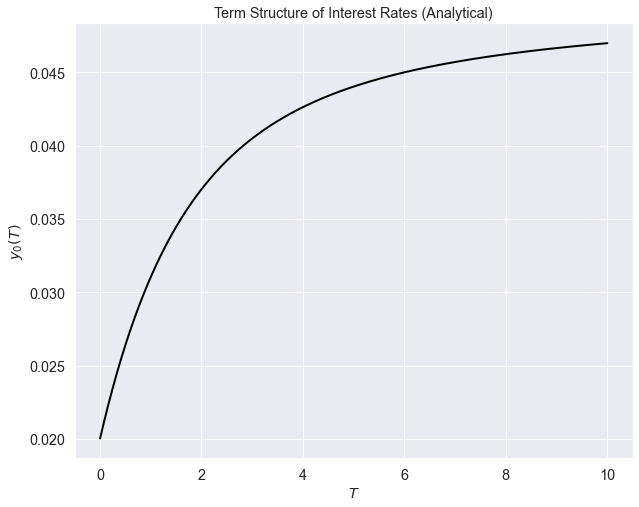

In [30]:
plt.figure(figsize=(10,8))
plt.plot(t[1:],bondyield1[1:],linewidth=2,color='black')
plt.ylabel(r"$y_0(T)$")
plt.xlabel(r"$T$")
plt.title("Term Structure of Interest Rates (Analytical)")
plt.show()

## 1.4 Comparison of Analytical and Simulation Results

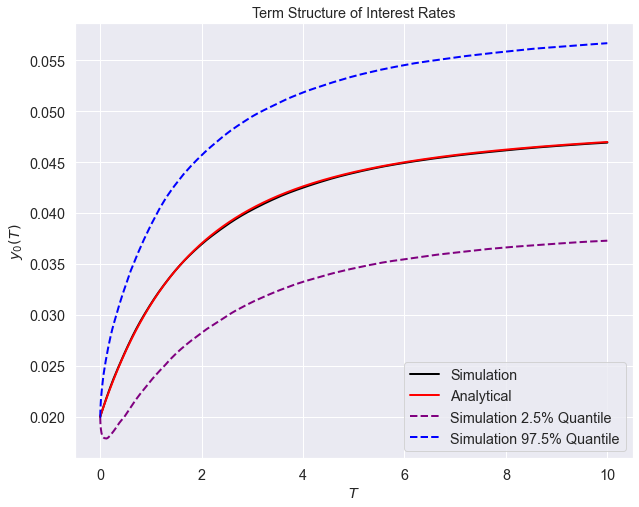

In [31]:
plt.figure(figsize=(10,8))
plt.plot(t,bond_yield_avg,linewidth=2,color='black',label="Simulation")
plt.plot(t[1:],bondyield1[1:],linewidth=2,color='red',label="Analytical")
plt.plot(tt[0,:],bond_yield2[0,:],linewidth=2,linestyle='dashed',color="purple",label="Simulation 2.5% Quantile");
plt.plot(tt[1,:],bond_yield2[1,:],linewidth=2,linestyle='dashed',color="blue",label="Simulation 97.5% Quantile");
plt.xlabel(r"$T$")
plt.ylabel(r"$y_0(T)$")
plt.title("Term Structure of Interest Rates")
plt.legend()
plt.show()

## Term Structure with Varying Parameters

In [ ]:
# Varying phi - long-term mean reversion level
fi1=0.04
fi2=0.045
fi3=0.055
fi4=0.06
bondyield2 = bondyield(alpha,beta,sigma, fi1, eta, t)
bondyield3 = bondyield(alpha,beta,sigma, fi2, eta, t)
bondyield4 = bondyield(alpha,beta,sigma, fi3, eta, t)
bondyield5 = bondyield(alpha,beta,sigma, fi4, eta, t)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(t[1:],bondyield2[1:],linewidth=2,color='lightblue',label='$\phi$ = 4.0%')
plt.plot(t[1:],bondyield3[1:],linewidth=2,color='blue',label='$\phi$ = 4.5%')
plt.plot(t[1:],bondyield1[1:],linewidth=2,color='black', label='$\phi$ = 5.0%')
plt.plot(t[1:],bondyield4[1:],linewidth=2,color='red',label='$\phi$ = 5.5%')
plt.plot(t[1:],bondyield5[1:],linewidth=2,color='pink',label='$\phi$ = 6.0%')

plt.xlabel(r"$T$")
plt.ylabel(r"$y_0(T)$")
plt.title("Term Structure of Interest Rates")
plt.legend()
plt.show()

In [ ]:
# Varying sigma - short rate volatility
sigma1=0.001
sigma2=0.1
sigma3=0.2
sigma4=0.4
bondyield6 = bondyield(alpha,beta,sigma1, fi, eta, t)
bondyield7 = bondyield(alpha,beta,sigma2, fi, eta, t)
bondyield8 = bondyield(alpha,beta,sigma3, fi, eta, t)
bondyield9 = bondyield(alpha,beta,sigma4, fi, eta, t)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(t[1:],bondyield6[1:],linewidth=2,color='blue',label='$\sigma$ = 0.001')
plt.plot(t[1:],bondyield1[1:],linewidth=2,color='black', label='$\sigma$ = 0.01')
plt.plot(t[1:],bondyield7[1:],linewidth=2,color='lightblue',label='$\sigma$ = 0.1')
plt.plot(t[1:],bondyield8[1:],linewidth=2,color='red',label='$\sigma$ = 0.2')
plt.plot(t[1:],bondyield9[1:],linewidth=2,color='pink',label='$\sigma$ = 0.4')

plt.xlabel(r"$T$")
plt.ylabel(r"$y_0(T)$")
plt.title("Term Structure of Interest Rates")
plt.legend()
plt.show()

In [ ]:
# Varying alpha - short term mean reversion rate 
alpha1=0.5
alpha2=2
alpha3=6
alpha4=10
bondyield10 = bondyield(alpha1,beta,sigma, fi, eta, t)
bondyield11 = bondyield(alpha2,beta,sigma, fi, eta, t)
bondyield12 = bondyield(alpha3,beta,sigma, fi, eta, t)
bondyield13 = bondyield(alpha4,beta,sigma, fi, eta, t)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(t[1:],bondyield10[1:],linewidth=2,color='lightblue',label=r'$\alpha$ = 0.5')
plt.plot(t[1:],bondyield11[1:],linewidth=2,color='blue',label=r'$\alpha$ = 2')
plt.plot(t[1:],bondyield1[1:],linewidth=2,color='black', label=r'$\alpha$ = 3')
plt.plot(t[1:],bondyield12[1:],linewidth=2,color='red',label=r'$\alpha$ = 6')
plt.plot(t[1:],bondyield13[1:],linewidth=2,color='pink',label=r'$\alpha$ = 10')


plt.xlabel(r"$T$")
plt.ylabel(r"$y_0(T)$")
plt.title("Term Structure of Interest Rates")
plt.legend()
plt.show()

In [ ]:
# Varying beta - long term mean reversion rate 
beta1=0.5
beta2=0.75
beta3=1.25
beta4=1.5
bondyield14 = bondyield(alpha,beta1,sigma, fi, eta, t)
bondyield15 = bondyield(alpha,beta2,sigma, fi, eta, t)
bondyield16 = bondyield(alpha,beta3,sigma, fi, eta, t)
bondyield17 = bondyield(alpha,beta4,sigma, fi, eta, t)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(t[1:],bondyield14[1:],linewidth=2,color='lightblue',label=r'$\beta$ = 0.5')
plt.plot(t[1:],bondyield15[1:],linewidth=2,color='blue',label=r'$\beta$ = 0.75')
plt.plot(t[1:],bondyield1[1:],linewidth=2,color='black', label=r'$\beta$ = 1')
plt.plot(t[1:],bondyield16[1:],linewidth=2,color='red',label=r'$\beta$ = 1.25')
plt.plot(t[1:],bondyield17[1:],linewidth=2,color='pink',label=r'$\beta$ = 1.5')


plt.xlabel(r"$T$")
plt.ylabel(r"$y_0(T)$")
plt.title("Term Structure of Interest Rates")
plt.legend()
plt.show()

In [ ]:
# Varying eta - long-term interest rate volatility
eta0=0.0005
eta1=0.025
eta2=0.045
eta3=0.1
eta4=0.15

bondyield180 = bondyield(alpha,beta,sigma, fi, eta0, t)
bondyield18 = bondyield(alpha,beta,sigma, fi, eta1, t)
bondyield19 = bondyield(alpha,beta,sigma, fi, eta2, t)
bondyield20 = bondyield(alpha,beta,sigma, fi, eta3, t)
bondyield21 = bondyield(alpha,beta,sigma, fi, eta4, t)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(t[1:],bondyield180[1:],linewidth=2,color='green',label='$\eta$ = 0.05%')
plt.plot(t[1:],bondyield1[1:],linewidth=2,color='black', label='$\eta$ = 0.50%')
plt.plot(t[1:],bondyield18[1:],linewidth=2,color='lightblue',label='$\eta$ = 2.50%')
plt.plot(t[1:],bondyield19[1:],linewidth=2,color='blue',label='$\eta$ = 5.00%')
plt.plot(t[1:],bondyield20[1:],linewidth=2,color='red',label='$\eta$ = 10.00%')
plt.plot(t[1:],bondyield21[1:],linewidth=2,color='pink',label='$\eta$ = 15.00%')

plt.xlabel(r"$T$")
plt.ylabel(r"$y_0(T)$")
plt.title("Term Structure of Interest Rates")
plt.legend()
plt.show()

# Bond Option Price

## Risk-Neutral Measure Simulation

**Step 1: Calculate $P_{T_1}(T_2)$ Distribution**

In [ ]:
# T2-T1 = delta_t = 5-3 = 2
delta_t = 2

In [ ]:
Bt = B(alpha, delta_t)
Bt

In [ ]:
Ct = C(alpha, beta, delta_t, Bt)
Ct

In [ ]:
At = A(alpha, beta, sigma, fi, eta, delta_t, Bt, Ct)
At

In [ ]:
# select the short rate process between T1=3 and T2=5
T1 = 365*3
T2 = 365*5

In [ ]:
PT1T2 = np.exp(At - Bt*r_t[:,T1] - Ct*theta[:,T1])
PT1T2

**Step 2: Calculate Strike Price $K=P_0(T_2)/P_0(T_1)$**

In [ ]:
# bond price calculated for various maturities using Monte Carlo Simulations in Question 1
bond_price

In [ ]:
# risk-neutral simulated T1 bond price
P0T1 = bond_price[T1]
P0T1

In [ ]:
# risk-neutral simulated T2 bond price
P0T2 = bond_price[T2]
P0T2

In [ ]:
# strike price
K = P0T2/P0T1
K

**Step 3: Simulate the discount factor and Take the average**

In [ ]:
# select the short rate process between t=0 and T1=3
r_t_P0T1 = r_t[:,:T1]
r_t_P0T1.shape

In [ ]:
# discretized increment
increment_t = np.zeros((1000,r_t_P0T1.shape[1]))
for i in range(1,r_t_P0T1.shape[1]):
    increment_t[:,i] = r_t_P0T1[:,i-1] * dt

In [ ]:
# integral of short rate process between 0 and T1
integral_t = np.zeros((1000,r_t_P0T1.shape[1]))
integral_t = np.cumsum(increment_t,axis=1)
integral_t.shape

In [ ]:
I = PT1T2 > K
payoff = I*(PT1T2-K)
bond_option_price1 = np.mean(np.exp(-integral_t[:,-1]) * payoff)
bond_option_price1

**Step 4: Consider a collection of strikes**

In [ ]:
alpha_2 = np.linspace(0.95,1.05,num=11)
alpha_2

In [ ]:
# collection of strikes
strikes = alpha_2*K
strikes

In [ ]:
# calculate bond option price for each strike
bond_option_price = np.zeros(strikes.shape)
for i in range(len(strikes)):
    I = PT1T2 > strikes[i]
    payoff = I*(PT1T2-strikes[i])
    bond_option_price[i] = np.mean(np.exp(-integral_t[:,-1]) * payoff)
bond_option_price

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(alpha_2,bond_option_price,linewidth=2,color='black',label="risk-neutral measure simulation")
plt.xlabel(r"$\alpha$")
plt.ylabel("Bond Option Price")
plt.title("Bond Option Prices Evaluated Using Various Methods")
plt.legend()
plt.show()

## Forward Neutral Measure Simulation

### Simulate the Long Rate Process

In [ ]:
def SimTheta_QT1(t, beta, fi, eta, Nsims):
    
    NdT = len(t)
    dt = t[1] - t[0]
    sqrt_dt = np.sqrt(dt)
    
    Bt = B(alpha, t)
    Ct = C(alpha, beta, t, Bt)
    
    theta_QT1 = np.zeros((Nsims, NdT))
    
    theta_QT1[:,0] = theta_0
    
    for i in range(len(t)-1):
        
        theta_QT1[:,i+1] = theta_QT1[:,i]+( beta*(fi-theta_QT1[:,i]) - eta**2 * Ct[i] )*dt+eta*sqrt_dt*np.random.randn(Nsims)
        
    return theta_QT1

In [ ]:
theta_QT1 = SimTheta_QT1(t[:T1], beta, fi, eta, Nsims=1000)

In [ ]:
plt.figure(figsize=(12,6))
for i in range(0,10):
  plt.plot(t[:T1],theta_QT1[i,:],linewidth=0.6)
plt.title('Short Rate $r_t$ Sample Paths (OU Process)')
plt.xlabel('Time(t)')
plt.ylabel(r'Short Rate $r_t$')
plt.show()

In [ ]:
fig = go.Figure()
for i in range(12):
    fig.add_trace(go.Scatter(x=t, y=theta_QT1[i,:], name="path " + str(i+1)) )

fig.update_layout(
    title=r"$\theta_t\quad\text{Sample Paths (T1 Bond Measure)}$",
    xaxis_title=r"$t$",
    yaxis_title=r"$\theta_t$",
    font=dict(
        size=18,
        color="RebeccaPurple") )

fig.show()

In [ ]:
def SimR_QT1(t, alpha, theta_QT1, sigma, Nsims):
    
    NdT = len(t)
    dt = t[1] - t[0]
    sqrt_dt = np.sqrt(dt)
    
    Bt = B(alpha, t)
    
    r_t_QT1 = np.zeros((Nsims, NdT))
    
    r_t_QT1[:,0] = r_0
    
    for i in range(len(t)-1):
        
        r_t_QT1[:,i+1] = r_t[:,i]+(alpha*(theta_QT1[:,i]-r_t_QT1[:,i]) - sigma**2*Bt[i])*dt+sigma*sqrt_dt*np.random.randn(Nsims)
        
    return r_t_QT1

In [ ]:
r_t_QT1 = SimR_QT1(t[:T1], alpha, theta_QT1, sigma, Nsims=1000)

In [ ]:
plt.figure(figsize=(12,6))
for i in range(0,10):
  plt.plot(t[:T1],r_t_QT1[i,:],linewidth=0.6)
plt.title('Short Rate $r_t$ Sample Paths (OU Process)')
plt.xlabel('Time(t)')
plt.ylabel(r'Short Rate $r_t$')
plt.show()

In [ ]:
fig = go.Figure()
for i in range(12):
    fig.add_trace(go.Scatter(x=t, y=r_t_QT1[i,:], name="path " + str(i+1)) )

fig.update_layout(
    title=r"$r_t\quad\text{Sample Paths}$",
    xaxis_title=r"$t$",
    yaxis_title=r"$r_t$",
    font=dict(
        size=18,
        color="RebeccaPurple") )

fig.show()

In [ ]:
theta_QT1 = SimTheta_QT1(t[:T1], beta, fi, eta, Nsims=1000)
r_t_QT1 = SimR_QT1(t[:T1], alpha, theta_QT1, sigma, Nsims=1000)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(t[:T1],theta_QT1[1,:],linewidth=1,color='green',alpha=0.75,label=r"$\theta_t$")
plt.plot(t[:T1],r_t_QT1[1,:],linewidth=1,color="red",alpha=0.75,label=r"$r_t$")
plt.xlabel(r"Time (t)")
plt.title("Short Rate and Long Rate Process (T1 Bond-Measure)")
plt.legend()
plt.show()

**Step 1: Calculate $P_{T_1}(T_2)$ Distribution**

In [ ]:
# T2-T1 = delta_t = 5-3 = 2
delta_t = 2

In [ ]:
Bt = B(alpha, delta_t)
Bt

In [ ]:
Ct = C(alpha, beta, delta_t, Bt)
Ct

In [ ]:
At = A(alpha, beta, sigma, fi, eta, delta_t, Bt, Ct)
At

In [ ]:
# select the short rate process between T1=3 and T2=5
T1 = 365*3
T2 = 365*5

In [ ]:
PT1T2_QT1 = np.exp(At - Bt*r_t_QT1[:,-1] - Ct*theta_QT1[:,-1])
PT1T2_QT1

**Step 2: Calculate Strike Price $K=P_0(T_2)/P_0(T_1)$**

In [ ]:
P0T1_analytical = bond_price_analytical[T1]
P0T1_analytical

In [ ]:
P0T2_analytical = bond_price_analytical[T2]
P0T2_analytical

In [ ]:
K_analytical = P0T2_analytical/P0T1_analytical
K_analytical

**Step 3: Take the average of the Payoff and Multiply by $P_0(T_1)$**

In [ ]:
I = PT1T2_QT1 > K_analytical
payoff_QT1 = I*(PT1T2_QT1-K_analytical)
bond_option_price1_QT1 = P0T1_analytical*np.mean(payoff_QT1)
bond_option_price1_QT1

In [ ]:
bond_option_price1

**Step 4: Consider a collection of strikes**

In [ ]:
# collection of strikes
strikes_QT1 = alpha_2*K_analytical
strikes_QT1

In [ ]:
# calculate bond option price for each strike
bond_option_price_QT1 = np.zeros(strikes_QT1.shape)
for i in range(len(strikes_QT1)):
    I = PT1T2_QT1 > strikes_QT1[i]
    payoff = I*(PT1T2_QT1-strikes_QT1[i])
    bond_option_price_QT1[i] = P0T1_analytical*np.mean(payoff)
bond_option_price_QT1

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(alpha_2,bond_option_price,linewidth=2,color='black',label="risk-neutral measure simulation")
plt.plot(alpha_2,bond_option_price_QT1,linewidth=2,color='red',label="forward-neutral measure simulation")
plt.xlabel(r"$\alpha$")
plt.ylabel("Bond Option Price")
plt.title("Bond Option Prices Evaluated Using Various Methods")
plt.legend()
plt.show()

### Analytical Solution

In [ ]:
omega_square_result=integrate.quad(lambda u: 
                                   sigma**2/(alpha**2)*
                                   (-np.exp(-alpha*(T2/365-u)) + np.exp(-alpha*(T1/365-u)))**2,
                                   0,3)

In [ ]:
omega_square = omega_square_result[0]
omega_square

In [ ]:
sigma_square_result = integrate.quad(lambda u: 
                                     eta**2*( alpha/(alpha-beta) )**2 *
                                     ( 1/beta *( -np.exp(-beta*(T2/365-u)) + np.exp(-beta*(T1/365-u)) )  
                                     + 1/alpha*( np.exp(-alpha*(T2/365-u)) - np.exp(-alpha*(T1/365-u))) )**2,0,3)
                                     
sigma_square = sigma_square_result[0]
sigma_square

In [ ]:
P0T1_analytical = bond_price_analytical[T1]
P0T1_analytical

In [ ]:
P0T2_analytical = bond_price_analytical[T2]
P0T2_analytical

In [ ]:
K_analytical = P0T2_analytical/P0T1_analytical
K_analytical

In [ ]:
X_0 = P0T2_analytical/P0T1_analytical
X_0

In [ ]:
dp = (np.log(X_0/K)+0.5*(omega_square+sigma_square))/(np.sqrt(omega_square+sigma_square))
dm = (np.log(X_0/K)-0.5*(omega_square+sigma_square))/(np.sqrt(omega_square+sigma_square))

In [ ]:
bond_option_price1_analytical = P0T2_analytical*norm.cdf(dp)-P0T1_analytical*K*norm.cdf(dm)
bond_option_price1_analytical

In [ ]:
# collection of strikes
strikes_analytical = alpha_2*K_analytical
strikes_analytical

In [ ]:
bond_option_price_analytical = np.zeros(alpha_2.shape)
for i in range(len(strikes_analytical)):
    dp = (np.log(X_0/strikes_analytical[i])+0.5*(omega_square+sigma_square))/(np.sqrt(omega_square+sigma_square))
    dm = (np.log(X_0/strikes_analytical[i])-0.5*(omega_square+sigma_square))/(np.sqrt(omega_square+sigma_square))
    bond_option_price_analytical[i] = P0T2_analytical*norm.cdf(dp)-P0T1_analytical*strikes_analytical[i]*norm.cdf(dm)

In [ ]:
bond_option_price_analytical

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(alpha_2,bond_option_price,linewidth=2,color='black',label="risk-neutral measure simulation")
plt.plot(alpha_2,bond_option_price_QT1,linewidth=2,color='red',label="forward-neutral measure simulation")
plt.plot(alpha_2,bond_option_price_analytical,linewidth=2,color='blue',label="forward-neutral measure analytical")
plt.xlabel(r"$\alpha$")
plt.ylabel("Bond Option Price")
plt.title("Bond Option Prices Evaluated Using Various Methods")
plt.legend()
plt.show()

In [ ]:
bond_option_price

In [ ]:
bond_option_price_QT1

In [ ]:
bond_option_price_analytical

# Swaption Implied Volatility

IRS tenor structure: $T_0=3, T_1=3.25,T_2=3.50,...,T_{12}=6$

$\Delta T = 0.25$

In [ ]:
# elapsed time interval between each payment date
delta_TT = 0.25

In [ ]:
# reset at 3 and payment date from 3.25 to 6
T_k = np.linspace(3.0,6,13)
T_k

## Strike Calculation

The strike is equal to today's swap rate: $S_0$

**Step 1: Obtain all the bond prices at t=0**

In [ ]:
# using risk-neutral simulation results
bond_price

In [ ]:
P0Tk = np.zeros(len(T_k))

for i in range(len(T_k)):
    T_kk = int(T_k[i]*365)
    P0Tk[i] = bond_price[T_kk]

P0Tk

**Step 2: Calculate $A_0$, annuity price at t=0**

In [ ]:
A_0 = np.sum(P0Tk[1:]*delta_TT)
A_0

**Step 3: Calculate $S_0$**

In [ ]:
swap_rate = (P0Tk[0]-P0Tk[-1])/A_0
swap_rate

In [ ]:
alpha_2

In [ ]:
# collection of strikes
swap_rate_strikes = alpha_2*swap_rate
swap_rate_strikes

## Swaption Price

**Step 1: Obtain all the bond prices at t=3**

In [ ]:
P3Tk = np.zeros((1000,len(T_k)))

for i in range(len(T_k)):
    delta_t = T_k[i] - T_k[0]
    Bt = B(alpha, delta_t)
    Ct = C(alpha, beta, delta_t, Bt)
    At = A(alpha, beta, sigma, fi, eta, delta_t, Bt, Ct)
    P3Tk[:,i] = np.exp(At - Bt*r_t[:,3*365] - Ct*theta[:,3*365])

P3Tk

**Step 2: Calculate the annuity price $A_3$**

In [ ]:
A_3 = np.sum(P3Tk[:,1:] * delta_TT,axis=1)
A_3

**Step 3: Calculate $S_3$**

In [ ]:
S_3 = (P3Tk[:,0] - P3Tk[:,-1])/A_3
S_3

**Step 4: Calculate the Payoff and Obtain the Swaption Price**

In [ ]:
swaption_sim_price = np.zeros(len(swap_rate_strikes))

for i in range(len(swap_rate_strikes)):
    
    I = S_3 > swap_rate_strikes[i]
    payoff = I*(S_3-swap_rate_strikes[i])
    swaption_sim_price[i] = A_0 * np.mean(payoff)

swaption_sim_price

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(swap_rate_strikes,swaption_sim_price,linewidth=2,color='black')
plt.xlabel("Strike Price")
plt.ylabel("Swaption Price")
plt.show()

## Calculate Implied Volatility

In [ ]:
S_0 = swap_rate
S_0

In [ ]:
A_0

In [ ]:
swap_rate_strikes

In [ ]:
swaption_sim_price

In [ ]:
implied_volatility = np.zeros(len(swap_rate_strikes))

for i in range(len(swap_rate_strikes)):
    
    def f(x):
        
        dp = (np.log(S_0/swap_rate_strikes[i]) + 0.5*x**2) / x
        dm = (np.log(S_0/swap_rate_strikes[i]) - 0.5*x**2) / x
        
        return A_0*(S_0*norm.cdf(dp) - swap_rate_strikes[i] * norm.cdf(dm)) - swaption_sim_price[i]
    
    omega = optimize.newton(f,0.5)
    implied_volatility[i] = omega/np.sqrt(3)

implied_volatility

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(swap_rate_strikes,implied_volatility,linewidth=2,color='black')
plt.xlabel("Swaption Strike Rates")
plt.ylabel("Implied Volatility")
plt.title("Swaption's Implied Volatility Variation")
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(implied_volatility,swaption_sim_price,linewidth=2,color='black')
plt.xlabel("Implied Volatility")
plt.ylabel("Swaption Price")
plt.title("Swaption's Price with Implied Volatility")
plt.show()